Import Dependencies

In [21]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import KFold
import numpy as np
import pandas as pd
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
from scipy import stats
import matplotlib.colors as colors

Load  data into a  DataFrame

In [22]:
# Load the data
mb_raw_data = pd.read_csv('../../data/mann_bruker.txt', sep='\t')

# Keep only necessary columns
mb_clean_frame = mb_raw_data[['Sequence', 'm/z', 'CCS','Mass','Charge','Length']]

# Perform z-score transformation
mb_clean_frame['CCS_z'] = stats.zscore(mb_clean_frame['CCS'])

# Save the mean and std for later use
ccs_mean = mb_clean_frame['CCS'].mean()
ccs_std = mb_clean_frame['CCS'].std()

# Delete the raw data frame to save memory
del mb_raw_data
# randomize data set
mb_clean_frame = mb_clean_frame.sample(frac=1, random_state=1)

C:\Users\Fabian Mathis\AppData\Local\Temp\ipykernel_20236\1776410603.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mb_clean_frame['CCS_z'] = stats.zscore(mb_clean_frame['CCS'])


Train Model

In [23]:
# Split the data into input (m/z) and output (CCS) variables
X = mb_clean_frame[["Charge", 'Mass', 'Length']]
y = mb_clean_frame['CCS_z']
# Define the number of folds
k = 4

Perform k-fold cross validation

In [24]:
# Initialize a dictionary to store the models for each charge
models = {}

# Loop over each charge
for charge in range(1, 5):
    # Filter the data for the current charge
    mb_charge_frame = mb_clean_frame[mb_clean_frame['Charge'] == charge]
    
    # Split the data into input and output variables
    X_charge = mb_charge_frame[['Mass', 'Length']]
    y_charge = mb_charge_frame['CCS_z']
    
    # Initialize the cross-validation object
    kf = KFold(n_splits=k)
    
    # Initialize lists to store the scores for each fold
    mse_scores_charge = []
    median_relative_errors_charge = []
    r2_scores_charge = []
    
    # Perform k-fold cross-validation
    for train_index, test_index in kf.split(X_charge):
        # Split the data into training and testing sets for the current fold
        X_train, X_test = X_charge.iloc[train_index], X_charge.iloc[test_index]
        y_train, y_test = y_charge.iloc[train_index], y_charge.iloc[test_index]
        
        # Create a linear regression model
        model = LinearRegression(n_jobs=-1)
        
        # Train the model
        model.fit(X_train, y_train)
        
        # Make predictions on the test set
        y_pred = model.predict(X_test)
        
        # Calculate the scores for the current fold
        mse_scores_charge.append(mean_squared_error(y_test, y_pred))
        median_relative_errors_charge.append(np.median(np.abs((y_pred - y_test) / y_test)))
        r2_scores_charge.append(r2_score(y_test, y_pred))
    
    # Create the final model for the current charge
    final_model_charge = LinearRegression(n_jobs=-1)
    final_model_charge.fit(X_charge, y_charge)
    
    # Store the final model in the dictionary
    models[charge] = final_model_charge
    
    # Print the scores for the current charge
    print(f'Charge: {charge}')
    print(f'Average Mean Squared Error: {np.mean(mse_scores_charge)}')
    print(f'Average Median Relative Error: {np.mean(median_relative_errors_charge)}')
    print(f'Average R^2 Score: {np.mean(r2_scores_charge)}')

# Now, 'models' is a dictionary that maps each charge to its corresponding model.
# You can access a model like this: models[charge]


Charge: 1
Average Mean Squared Error: 0.0015231823132145134
Average Median Relative Error: 0.011810920806623779
Average R^2 Score: 0.7115716958340672
Charge: 2
Average Mean Squared Error: 0.009729692108314028
Average Median Relative Error: 0.2502552077124136
Average R^2 Score: 0.902466050993026
Charge: 3
Average Mean Squared Error: 0.03935691448260347
Average Median Relative Error: 0.08947021976160227
Average R^2 Score: 0.7812191291463211
Charge: 4
Average Mean Squared Error: 0.09374214000942582
Average Median Relative Error: 0.06372065242754399
Average R^2 Score: 0.6688222109002704


Save the model

C:\Users\Fabian Mathis\AppData\Local\Temp\ipykernel_20236\321297042.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mb_charge_frame['Predicted CCS'] = models[charge].predict(mb_charge_frame[['Mass', 'Length']])
C:\Users\Fabian Mathis\AppData\Local\Temp\ipykernel_20236\321297042.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mb_charge_frame['Predicted CCS'] = mb_charge_frame['Predicted CCS'] * ccs_std + ccs_mean
C:\Users\Fabian Mathis\AppData\Local\Temp\ipykernel_20236\321297042.py:13: SettingWith

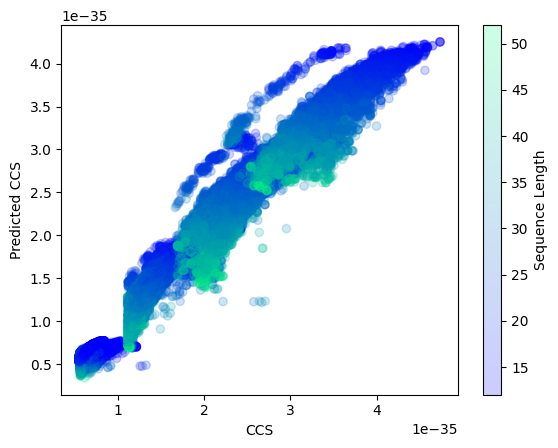

In [25]:
# Create a new figure
fig, ax = plt.subplots()

# Define the colormap
cmap = plt.get_cmap('winter')

# Loop over each charge
for charge in range(1, 5):
    # Filter the data for the current charge
    mb_charge_frame = mb_clean_frame[mb_clean_frame['Charge'] == charge]
    
    # Predict the CCS values using the model for the current charge
    mb_charge_frame['Predicted CCS'] = models[charge].predict(mb_charge_frame[['Mass', 'Length']])
    
    # Reverse the z-score transformation
    mb_charge_frame['Predicted CCS'] = mb_charge_frame['Predicted CCS'] * ccs_std + ccs_mean
    
    # Create a scatter plot of the error between the predicted and actual CCS values by sequence length
    sc = ax.scatter(
        mb_charge_frame['CCS'],
        mb_charge_frame['Predicted CCS'],
        c=mb_charge_frame['Length'],
        cmap=cmap,
        alpha=0.2,
        vmin=mb_charge_frame['Length'].min(),
        vmax=mb_charge_frame['Length'].max()
    )

# Add a colorbar to the figure
fig.colorbar(sc, ax=ax, label='Sequence Length')

# Add labels to the axes
ax.set_xlabel('CCS')
ax.set_ylabel('Predicted CCS')

# Show the figure
plt.show()


C:\Users\Fabian Mathis\AppData\Local\Temp\ipykernel_20236\2172017209.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mb_charge_frame['Predicted CCS'] = models[key].predict(mb_charge_frame[['Mass', 'Length']])
C:\Users\Fabian Mathis\AppData\Local\Temp\ipykernel_20236\2172017209.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mb_charge_frame['Predicted CCS'] = mb_charge_frame['Predicted CCS'] * ccs_std + ccs_mean


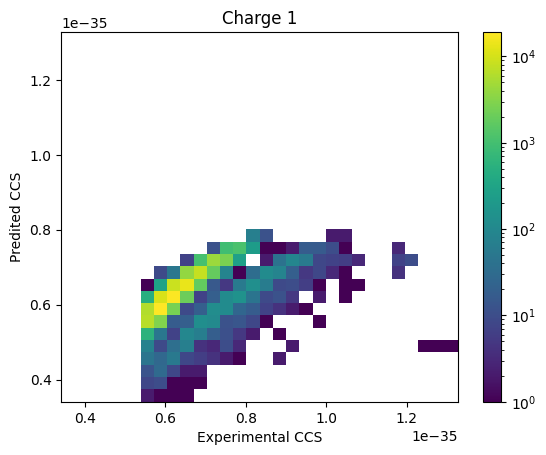

C:\Users\Fabian Mathis\AppData\Local\Temp\ipykernel_20236\2172017209.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mb_charge_frame['Predicted CCS'] = models[key].predict(mb_charge_frame[['Mass', 'Length']])
C:\Users\Fabian Mathis\AppData\Local\Temp\ipykernel_20236\2172017209.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mb_charge_frame['Predicted CCS'] = mb_charge_frame['Predicted CCS'] * ccs_std + ccs_mean


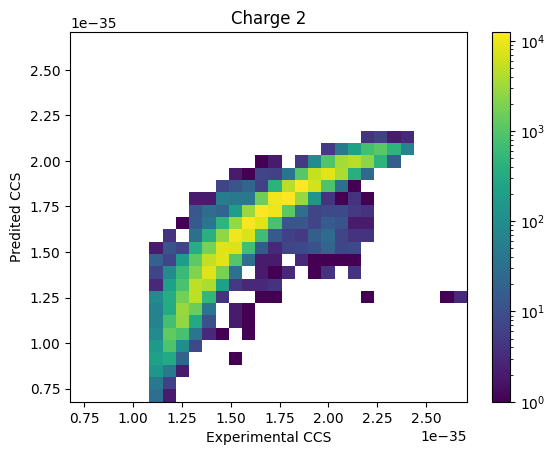

C:\Users\Fabian Mathis\AppData\Local\Temp\ipykernel_20236\2172017209.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mb_charge_frame['Predicted CCS'] = models[key].predict(mb_charge_frame[['Mass', 'Length']])
C:\Users\Fabian Mathis\AppData\Local\Temp\ipykernel_20236\2172017209.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mb_charge_frame['Predicted CCS'] = mb_charge_frame['Predicted CCS'] * ccs_std + ccs_mean


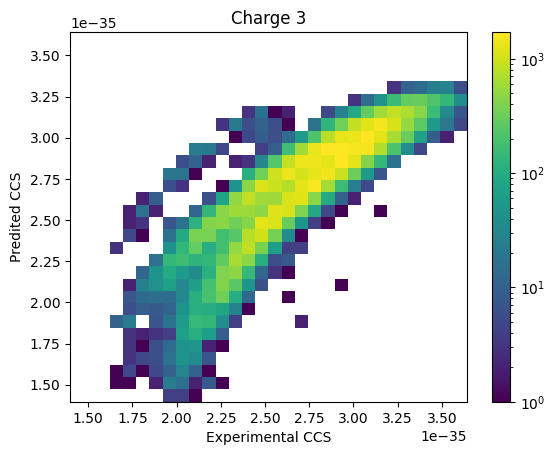

C:\Users\Fabian Mathis\AppData\Local\Temp\ipykernel_20236\2172017209.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mb_charge_frame['Predicted CCS'] = models[key].predict(mb_charge_frame[['Mass', 'Length']])
C:\Users\Fabian Mathis\AppData\Local\Temp\ipykernel_20236\2172017209.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mb_charge_frame['Predicted CCS'] = mb_charge_frame['Predicted CCS'] * ccs_std + ccs_mean


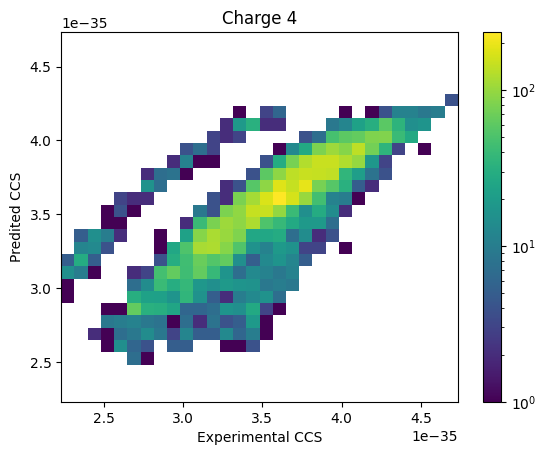

In [149]:
for key in models:
    mb_charge_frame = mb_clean_frame[mb_clean_frame['Charge'] == key]

    # Predict the CCS of the peptides in the data frame
    mb_charge_frame['Predicted CCS'] = models[key].predict(mb_charge_frame[['Mass', 'Length']])

    # Reverse the z-score transformation
    mb_charge_frame['Predicted CCS'] = mb_charge_frame['Predicted CCS'] * ccs_std + ccs_mean

    ccs_data = mb_charge_frame["CCS"].to_numpy()
    predicted_ccs_data = mb_charge_frame["Predicted CCS"].to_numpy()

    x = mb_charge_frame["CCS"]
    y = mb_charge_frame["Predicted CCS"]

    plt_min = [mb_charge_frame["CCS"].min(), mb_charge_frame["Predicted CCS"].min()]
    plt_max = [mb_charge_frame["CCS"].max(), mb_charge_frame["Predicted CCS"].max()]

    range_min = 0
    range_max = 0

    if plt_min[0] < plt_min[1]:
        range_min = plt_min[0]
    else:
        range_min = plt_min[1]

    if plt_max[0] > plt_max[1]:
        range_max = plt_max[0]
    else:
        range_max = plt_max[1]

    if key == 100:
        plt.hist2d(x, y, bins=[30,30], norm=colors.LogNorm(), range=((0, 1.4*1e-35), (0, 1.4*1e-35)))
    else:
        plt.hist2d(x, y, bins=[30,30], norm=colors.LogNorm(), range=((range_min, range_max), (range_min, range_max)))
    plt.colorbar()
    plt.title(f"Charge {key}")
    plt.xlabel("Experimental CCS")
    plt.ylabel("Predited CCS")
    plt.show()

C:\Users\Fabian Mathis\AppData\Local\Temp\ipykernel_20236\1116072152.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mb_charge_frame['Predicted CCS'] = models[key].predict(mb_charge_frame[['Mass', 'Length']])
C:\Users\Fabian Mathis\AppData\Local\Temp\ipykernel_20236\1116072152.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mb_charge_frame['Predicted CCS'] = mb_charge_frame['Predicted CCS'] * ccs_std + ccs_mean


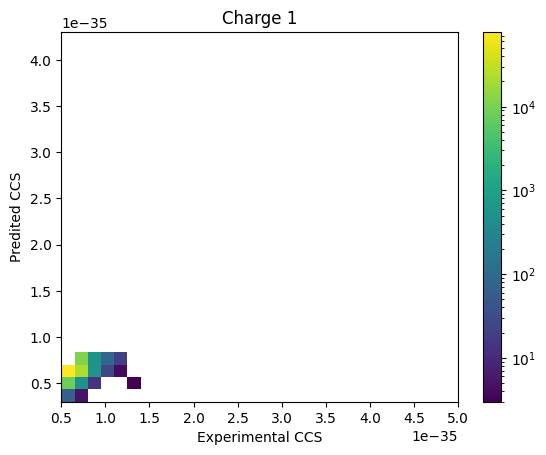

C:\Users\Fabian Mathis\AppData\Local\Temp\ipykernel_20236\1116072152.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mb_charge_frame['Predicted CCS'] = models[key].predict(mb_charge_frame[['Mass', 'Length']])
C:\Users\Fabian Mathis\AppData\Local\Temp\ipykernel_20236\1116072152.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mb_charge_frame['Predicted CCS'] = mb_charge_frame['Predicted CCS'] * ccs_std + ccs_mean


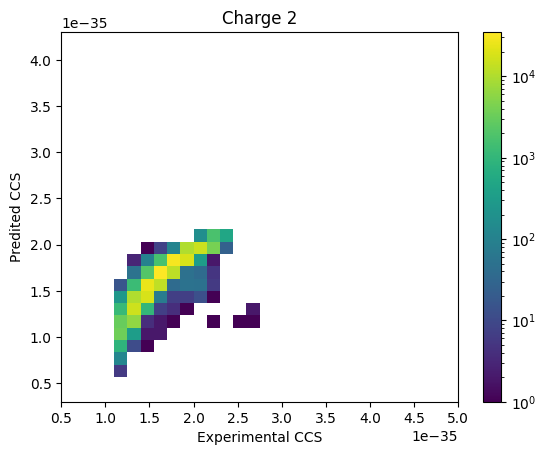

C:\Users\Fabian Mathis\AppData\Local\Temp\ipykernel_20236\1116072152.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mb_charge_frame['Predicted CCS'] = models[key].predict(mb_charge_frame[['Mass', 'Length']])
C:\Users\Fabian Mathis\AppData\Local\Temp\ipykernel_20236\1116072152.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mb_charge_frame['Predicted CCS'] = mb_charge_frame['Predicted CCS'] * ccs_std + ccs_mean


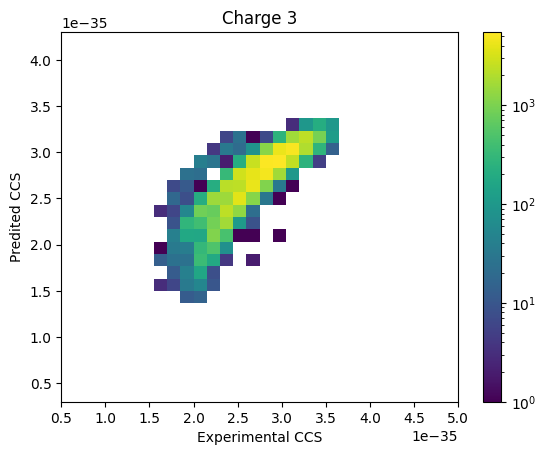

C:\Users\Fabian Mathis\AppData\Local\Temp\ipykernel_20236\1116072152.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mb_charge_frame['Predicted CCS'] = models[key].predict(mb_charge_frame[['Mass', 'Length']])
C:\Users\Fabian Mathis\AppData\Local\Temp\ipykernel_20236\1116072152.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mb_charge_frame['Predicted CCS'] = mb_charge_frame['Predicted CCS'] * ccs_std + ccs_mean


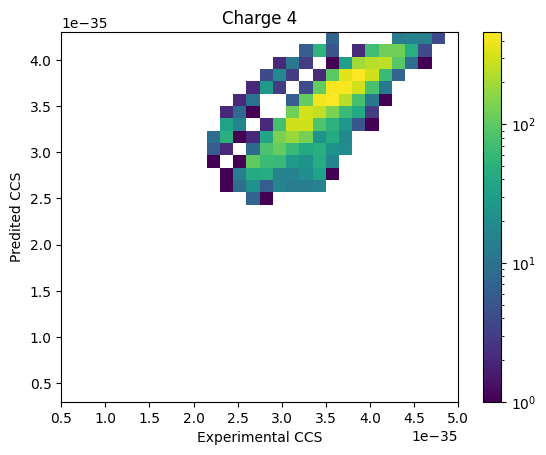

In [109]:
for key in models:
    mb_charge_frame = mb_clean_frame[mb_clean_frame['Charge'] == key]
    # Predict the CCS of the peptides in the data frame
    mb_charge_frame['Predicted CCS'] = models[key].predict(mb_charge_frame[['Mass', 'Length']])

    # Reverse the z-score transformation
    mb_charge_frame['Predicted CCS'] = mb_charge_frame['Predicted CCS'] * ccs_std + ccs_mean

    ccs_data = mb_charge_frame["CCS"].to_numpy()
    predicted_ccs_data = mb_charge_frame["Predicted CCS"].to_numpy()

    x = mb_charge_frame["CCS"]
    y = mb_charge_frame["Predicted CCS"]

    plt.hist2d(x, y, bins=[30,30], norm=colors.LogNorm(), range=((0.5*1e-35, 5*1e-35), (3*1e-36, 4.3*1e-35)))
    plt.colorbar()
    plt.title(f"Charge {key}")
    plt.xlabel("Experimental CCS")
    plt.ylabel("Predited CCS")
    plt.show()

Save the model to a file

In [ ]:
#filename = '../../models/lin_reg/lin_reg.pkl'
#pickle.dump(model, open(filename, 'wb'))